# PassingTask_v10 : 他者のモデルを内包するすれ違い

後方移動の制限・グラフ用出力カイゼン

***

x,yそれぞれの４状態、位置、衝突、行動の観測

***

## Import

In [1]:
# update pip if you need

#!pip install -U pip
#!pip --version

#!pip install -U pyglet

In [2]:
#!pip install git+https://github.com/infer-actively/pymdp.git@agent_jax
#invalid
#!pip install inferactively-pymdp #overwrite with pymdp get from github (cpntains jax)

In [3]:
#check cuda information
#!nvcc -V #there's no problem if "command not found"
#!nvidia-smi

In [4]:
# install jax for TPU on Google Colab
#!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

# CUDA 12.X installation
#!pip install -U "jax[cuda12]"

#CPU [if you want to run on Windows]
#!pip install -U "jax[cpu]

#!export PATH="/usr/local/cuda/bin:$PATH" (no need)
#!export LD_LIBRARY_PATH="/usr/local/cuda/lib64:$LD_LIBRARY_PATH"

In [5]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import random as jr, config, jit
from jax import nn, device_get
from pymdp.jax.agent import Agent as AIFAgent
from functools import partial
from equinox import tree_at

config.update("jax_default_matmul_precision", "float32")
#config.update('jax_platform_name', 'cpu') # CPUで動かすときは実行する

#check jax
print(f'Jax backend: {jax.default_backend()}')
print("devices:", jax.devices())

Jax backend: cpu
devices: [CpuDevice(id=0)]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pymdp import utils
import time
from pymdp.maths import softmax

import pyglet
print(f'pyglet : {pyglet.version}')

pyglet : 2.1.11


## 表示用関数

In [7]:
#matrix display function
def matrixDisplay(window :pyglet.window.Window, Appender, batch, matrix :np.array, x, y, width = 10, fill_rate = 0.8, high_color = (50,0,150), low_color = (240,240,240), Trans = False):
    lower_val = matrix.min()
    max_val = matrix.max() - lower_val
    if matrix.ndim == 1:  # 1次元配列の場合
        matrix = matrix.reshape(-1, 1)  # 2次元配列に変換
    if Trans:
        matrix = matrix.T

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            level = (matrix[i,j]-lower_val)/(max_val+1e-16)
            interpolated_color = (
                int(low_color[0]*(1 - level) + high_color[0]*level),
                int(low_color[1]*(1 - level) + high_color[1]*level),
                int(low_color[2]*(1 - level) + high_color[2]*level))
            Appender(pyglet.shapes.Rectangle(x+j*width, y+i*width, width*fill_rate, width*fill_rate, color=interpolated_color, batch=batch))
    # Ensure the position is within the screen bounds
    name_x = max(0, min(window.width, x + matrix.shape[1] / 2.0 * width))
    name_y = max(0, min(window.height, y - 15))
    return (name_x, name_y)

#Display matrix as Image Sprite
def matrixImageDisplay(window :pyglet.window.Window, Appender, batch, matrix :np.array, x, y, scale :float = 1.0, high_color = (50,0,150), low_color = (240,240,240), Trans = False):
    lower_val = matrix.min()
    max_val = matrix.max() - lower_val
    if matrix.ndim == 1:  # 1次元配列の場合
        matrix = matrix.reshape(-1, 1)  # 2次元配列に変換
    if Trans:
        matrix = matrix.T

    data = np.zeros((matrix.shape + (3,)), dtype=np.uint8)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            level = (matrix[i,j]-lower_val)/(max_val+1e-16)
            data[i,j] = [
                int(low_color[0]*(1 - level) + high_color[0]*level),
                int(low_color[1]*(1 - level) + high_color[1]*level),
                int(low_color[2]*(1 - level) + high_color[2]*level)]
    raw_image = pyglet.image.ImageData(data.shape[1], data.shape[0], 'RGB', data.tobytes())
    tempSprite = pyglet.sprite.Sprite(raw_image, x, y, batch=batch)
    pyglet.gl.glTexParameteri(pyglet.gl.GL_TEXTURE_2D, pyglet.gl.GL_TEXTURE_MAG_FILTER, pyglet.gl.GL_NEAREST)
    pyglet.gl.glTexParameteri(pyglet.gl.GL_TEXTURE_2D, pyglet.gl.GL_TEXTURE_MIN_FILTER, pyglet.gl.GL_NEAREST)
    tempSprite.scale = scale
    Appender(tempSprite)
    # Ensure the position is within the screen bounds
    name_x = max(0, min(window.width, x + matrix.shape[1] / 2.0 * scale))
    name_y = max(0, min(window.height, y - 15))
    return (name_x, name_y)

#bar plot function for action probability
def barplotDisplay(window :pyglet.window.Window, Appender, batch, array, x, y, width = 30, height = 50, fill_rate = 0.8, bar_color = (50,50,255), line_color = (0,0,0), line_width = 1):
    array = array/array.sum()
    for i in range(len(array)):
       Appender(pyglet.shapes.Rectangle(x+i*width+int(width*(1-fill_rate)), y, width*fill_rate, int(array[i]*height), color=bar_color, batch=batch))
    Appender(pyglet.shapes.Line(x, y, x + len(array)*width, y, line_width, color = line_color, batch=batch))
    Appender(pyglet.shapes.Line(x, y, x, y + height, line_width, color = line_color, batch=batch))
    name_x = max(0, min(window.width, x + int(len(array)*width/2)))
    name_y = max(0, min(window.height, y + height + 20))
    return (name_x, name_y)

def stackedBarplotDisplay(window :pyglet.window.Window, Appender, batch, matrix :np.array, x, y, width = 30, height = 50, fill_rate = 0.8, bar_color_pallete :list = [(220,220,50), (240,30,30), (50,200,50), (120,170,200), (200,100,220)], line_color = (0,0,0), line_width = 1):
    posmax = np.where(matrix>0,matrix,0.).sum(axis=1).max()
    negmax = np.where(matrix<0,matrix,0.).sum(axis=1).min()
    scale :float = height / (posmax - negmax) if posmax != negmax else 0.
    baseline :int = int(y - negmax * scale)
    margin :int = int(width*(1-fill_rate))
    for i in range(matrix.shape[0]):
        posStack :float = 0.
        negStack :float = 0.
        for h in range(matrix.shape[1]): #need enough color pallete for h
            if matrix[i,h] < 0:
                negStack += matrix[i,h] * scale
                Appender(pyglet.shapes.Rectangle(x+i*width+margin, baseline + negStack, width*fill_rate, -matrix[i,h]*scale, color=bar_color_pallete[h], batch=batch))
            elif matrix[i,h] > 0:
                Appender(pyglet.shapes.Rectangle(x+i*width+margin, baseline + posStack, width*fill_rate, matrix[i,h]*scale, color=bar_color_pallete[h], batch=batch))
                posStack += matrix[i,h] * scale
    Appender(pyglet.shapes.Line(x, baseline, x + matrix.shape[0]*width, baseline, line_width, color = line_color, batch=batch))
    Appender(pyglet.shapes.Line(x, y, x, y + height, line_width, color = line_color, batch=batch))
    name_x = max(0, min(window.width, x + int(matrix.shape[0]*width/2)))
    name_y = max(0, min(window.height, y + height + 20))
    return (name_x, name_y)

def colorLegend(Appender, batch, x :int, y: int, name_list :list, font_name = 'Times New Roman', font_size = 9, rate = 1.5, color_pallete :list = [(220,220,50), (240,30,30), (50,200,50), (120,170,200), (200,100,220)], font_color = (0, 0, 0)):
    margin = int(font_size*rate)
    for i in range(len(name_list)):
        Appender(pyglet.shapes.Rectangle(x, y-i*margin-int(font_size*.5), font_size, font_size, color=color_pallete[i], batch=batch))
        Appender(pyglet.text.Label(name_list[i], font_name=font_name, font_size=font_size,
                                    x=x+margin, y=y-i*margin, color = font_color + (255,), #color and alpha
                                    anchor_x='left', anchor_y='center', batch=batch))
    return

def actionDisplay(Appender, batch, action :int, x, y, backColor, onColor, offColor, width=50, marginRate = 0.2) -> None:
    margin = int(marginRate*width)
    Appender(pyglet.shapes.Rectangle(x, y, margin*4+width*3, margin*3+width*2, color=backColor, batch=batch)) #黒四角
    Appender(pyglet.shapes.Rectangle(x+margin, y+margin, width, width,
                        color=onColor if action==2 else offColor, batch=batch))
    Appender(pyglet.shapes.Rectangle(x+margin*2+width, y+margin*2+width, width, width,
                        color=onColor if action==3 else offColor, batch=batch))
    Appender(pyglet.shapes.Rectangle(x+margin*2+width, y+margin, width, width,
                        color=onColor if action==4 else offColor, batch=batch))
    Appender(pyglet.shapes.Rectangle(x+margin*3+width*2, y+margin, width, width,
                        color=onColor if action==1 else offColor, batch=batch))
    return

def drawMatrix2Image(Appender, matrix :np.array, x, y, batch, scale :float = 5.0):
    raw_image = pyglet.image.ImageData(matrix.shape[1], matrix.shape[0], 'RGB', matrix.tobytes())
    tempSprite = pyglet.sprite.Sprite(raw_image, x, y, batch=batch)
    pyglet.gl.glTexParameteri(pyglet.gl.GL_TEXTURE_2D, pyglet.gl.GL_TEXTURE_MAG_FILTER, pyglet.gl.GL_NEAREST)
    pyglet.gl.glTexParameteri(pyglet.gl.GL_TEXTURE_2D, pyglet.gl.GL_TEXTURE_MIN_FILTER, pyglet.gl.GL_NEAREST)
    tempSprite.scale = scale
    Appender(tempSprite)

2025-12-08 16:31:46.523 Python[7548:135951] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/cg/43m2llrs0pl8mgtft15vz2h00000gp/T/org.python.python.savedState


## A,B,C,Dの設定

In [8]:
x_division = 10 #縦方向
y_division = 20 #横方向
col_division = 10 #衝突の観測
actiondivision = 3

num_obs = [x_division, y_division, actiondivision, actiondivision, x_division, y_division, actiondivision, actiondivision, col_division]
num_modalities = len(num_obs)
num_states = [x_division, y_division, actiondivision, actiondivision, x_division, y_division, actiondivision, actiondivision]
print(f'num_obs : {num_obs}')
print(f'num_modalities : {num_modalities}')
print(f'num_states : {num_states}')
num_factors = len(num_states) # the total number of hidden state factors

num_controls = [actiondivision, actiondivision, actiondivision, actiondivision, actiondivision, actiondivision, actiondivision, actiondivision] # a list of the dimensionalities of each control state factor
control_fac_idx = [0, 1, 2, 3, 4, 5, 6, 7] #実質[0,1,2,3,4,5,6,7]で計算されている＝Noneと変わらない　注意
policies = [
    jnp.stack([
        np.array([[i, j, i, j, k, l, k, l]]) #[0,1,0,1,2,1,2,1]のような形で行動を共通化させた組み合わせのポリシーを作成
        for i in range(num_controls[0])
        for j in [1,2]#range(num_controls[1])
        for k in range(num_controls[4])
        for l in [0,1]#range(num_controls[5])
    ]),
    jnp.stack([
        np.array([[i, j, i, j, k, l, k, l]]) #[0,1,0,1,2,1,2,1]のような形で行動を共通化させた組み合わせのポリシーを作成
        for i in range(num_controls[0])
        for j in [0,1]#range(num_controls[1])
        for k in range(num_controls[4])
        for l in [1,2]#range(num_controls[5])
    ])
]
num_control_factors = len(num_controls) # the total number of control state factors
print(f'num_controls : {num_controls}')
print(f'num_control_factors : {num_control_factors}')

A_dependencies = [[0], [1], [2], [3], [4], [5], [6], [7], [0, 1, 4, 5]]
print(f'A_dependencies : {A_dependencies}')

B_dependencies = [[0], [1], [2], [3], [4], [5], [6], [7]]
print(f'B_dependencies : {B_dependencies}')

#A = utils.initialize_empty_A(num_obs, num_states)
A = utils.random_A_matrix(num_obs, num_states, A_dependencies)
A = A*0. + 1
A = utils.norm_dist_obj_arr(A)

#utils.plot_likelihood(A[0][:,:,2], title = "P(o(0) | s(0))" )
print(f'A[0].shape : {A[0].shape}')
print(f'A[8].shape : {A[8].shape}')
print(f'A is normalized : {utils.is_normalized(A)}') #[modality][0,:,:]

B = utils.random_B_matrix(num_states, num_controls, B_dependencies)
B = B*0. + 1
B = utils.norm_dist_obj_arr(B)

print(f'B[0].shape : {B[0].shape}')
print(f'B[1].shape : {B[1].shape}')
print(f'B[2].shape : {B[2].shape}')
print(f'B is normalized : {utils.is_normalized(B)}') #[state][0,:,:,action]

M_PREF = -.2
C :list[np.array] = []
C.append(utils.obj_array_zeros([num_ob for num_ob in num_obs]))
#C[2] = np.array([-1, 4])
C[0][0] = np.log(softmax(-np.linspace(-1.0, 1.0, num_obs[0]) ** 2 * 2.0)) # x division
#utils.plot_beliefs(C[0][0], title = "C[0][0]" )
C[0][1] = np.log(softmax(np.linspace(-1, 20, num_obs[1])))
C[0][2] = np.log(softmax(np.array([M_PREF,0,M_PREF]))) # x dir pref
C[0][3] = np.log(softmax(np.array([M_PREF,0,-M_PREF*2.0])))
C[0][4] = np.log(softmax(-np.linspace(-1.0, 1.0, num_obs[4]) ** 2 * 2.0)) # x division
C[0][5] = np.log(softmax(np.linspace(20, -1, num_obs[5])))
C[0][6] = np.log(softmax(np.array([M_PREF,0,M_PREF]))) # x dir pref
C[0][8] = np.log(softmax(np.linspace(-1, 8, num_obs[8]))) # col pref
print(f'C_0 : {C[0]}')
C.append(utils.obj_array_zeros([num_ob for num_ob in num_obs]))
C[1][0] = np.log(softmax(-np.linspace(-1.0, 1.0, num_obs[0]) ** 2 * 2.0)) # x division
C[1][1] = np.log(softmax(np.linspace(20, -1, num_obs[1]))) # set preference on agent2pos
C[1][2] = np.log(softmax(np.array([M_PREF,0,M_PREF]))) # x dir pref
C[1][3] = np.log(softmax(np.array([-M_PREF*2.0,0,M_PREF])))
C[1][4] = np.log(softmax(-np.linspace(-1.0, 1.0, num_obs[4]) ** 2 * 2.0)) # x division
C[1][5] = np.log(softmax(np.linspace(-1, 20, num_obs[5])))
C[1][6] = np.log(softmax(np.array([M_PREF,0,M_PREF]))) # x dir pref
C[1][8] = np.log(softmax(np.linspace(-1, 8, num_obs[8]))) # col pref

Alpha :list[jnp.array] = []
#Alpha.append(None)
#Alpha.append(None)
instAlpha :float = 0.5
Alpha.append(jnp.array([(1.-instAlpha)*2, (1.-instAlpha)*2, (1.-instAlpha)*2, (1.-instAlpha)*2, 
                        instAlpha*2, instAlpha*2, instAlpha*2, instAlpha*2, 
                        1.]))
Alpha.append(jnp.array([instAlpha*2, instAlpha*2, instAlpha*2, instAlpha*2,
                        (1.-instAlpha)*2, (1.-instAlpha)*2, (1.-instAlpha)*2, (1.-instAlpha)*2, 
                        1.]))
RecordParam = {'CurrentIdx':0,
               'Alpha':[],
               'CurrentEpoch':0,
               'MaxEpoch':30}
RecordParam['Alpha'] = [
    [
        jnp.array([i*2, i*2, i*2, i*2, (1.-i)*2, (1.-i)*2, (1.-i)*2, (1.-i)*2, 1.]),
        jnp.array([j*2, j*2, j*2, j*2, (1.-j)*2, (1.-j)*2, (1.-j)*2, (1.-j)*2, 1.])
    ] 
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for j in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
]

pA = utils.dirichlet_like(A, scale = 1e-1)
pA = utils.random_A_matrix(num_obs, num_states, A_dependencies)
for i in range(8):
    pA[i] += np.eye(num_obs[i])*1e+1
#pA = [np.random.rand(num_obs[i], num_states[0]) for i in range(num_modalities)]
for i_x in range(num_states[0]):
    for i_y in range(num_states[1]):
        for j_x in range(num_states[0]):
            for j_y in range(num_states[1]):
                agent_distance = np.sqrt((i_x - j_x)**2 + (i_y - j_y)**2)
                pA[8][:,i_x,i_y,j_x,j_y] += 1e+1*nn.one_hot(max(0, min(col_division-1, int(agent_distance*2))), col_division)
print(f'pA.shape : {A[6].shape}')

pB = utils.dirichlet_like(B, scale = 1e-1)
for i in [0,1,4,5]:
    pB[i][:,:,1] += np.eye(num_states[i])*1e+1
    pB[i][:,:,0] += np.eye(num_states[i])*1e+1
    pB[i][:,1:,0] = np.roll(pB[i][:,:,0], shift=1, axis=1)[:,1:]
    pB[i][:,:,2] += np.eye(num_states[i])*1e+1
    pB[i][:,:-1,2] = np.roll(pB[i][:,:,2], shift=-1, axis=1)[:,:-1]
for i in [2,3,6,7]:
    for j in range(3):
        pB[i][j,:,j] += np.ones(num_states[i])*1e+1
print(f'pB.shape : {B.shape}')

D = utils.obj_array_ones([num_state for num_state in num_states])
for i in range(num_factors):
    D[i] = softmax(D[i])
#a = 2.0 / ((int(num_states[0])-1)/2)
#x = np.linspace(0, int(num_states[0])-1, int(num_states[0])) - (int(num_states[0])-1)/2
#print(f'x : {x}')
#D[0] = softmax(np.log(1/(1+np.exp(-a*x))))

print(f'D : {D}')
#utils.plot_beliefs(D[0], title = "Prior beliefs about probability of s(0)")

#check A dependencies
for m in range(num_modalities): #check A is  setted
    factor_dims = tuple([num_states[f] for f in A_dependencies[m]])
    assert A[m].shape[1:] == factor_dims, f"Please input an `A_dependencies` whose {m}-th indices pick out the hidden state factors that line up with lagging dimensions of A{m}..."
    if pA is not None:
        assert pA[m].shape[1:] == factor_dims, f"Please input an `A_dependencies` whose {m}-th indices pick out the hidden state factors that line up with lagging dimensions of pA{m}..."

num_obs : [10, 20, 3, 3, 10, 20, 3, 3, 10]
num_modalities : 9
num_states : [10, 20, 3, 3, 10, 20, 3, 3]
num_controls : [3, 3, 3, 3, 3, 3, 3, 3]
num_control_factors : 8
A_dependencies : [[0], [1], [2], [3], [4], [5], [6], [7], [0, 1, 4, 5]]
B_dependencies : [[0], [1], [2], [3], [4], [5], [6], [7]]
A[0].shape : (10, 10)
A[8].shape : (10, 10, 20, 10, 20)
A is normalized : True
B[0].shape : (10, 10, 3)
B[1].shape : (20, 20, 3)
B[2].shape : (3, 3, 3)
B is normalized : True
C_0 : [array([-3.70450271, -2.91437925, -2.32178666, -1.92672493, -1.72919406,
        -1.72919406, -1.92672493, -2.32178666, -2.91437925, -3.70450271])
 array([-21.40215619, -20.29689303, -19.19162987, -18.08636671,
        -16.98110356, -15.8758404 , -14.77057724, -13.66531408,
        -12.56005092, -11.45478777, -10.34952461,  -9.24426145,
         -8.13899829,  -7.03373514,  -5.92847198,  -4.82320882,
         -3.71794566,  -2.6126825 ,  -1.50741935,  -0.40215619])
 array([-1.1698169, -0.9698169, -1.1698169])
 array([

In [9]:
batch_size = 1 # number of agents


A_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(A))
B_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(B))
C_jax = []
for i in range(2):
    C_jax.append(jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(C[i])))
D_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(D))
#E_jax = jnp.ones((batch_size, length_of_policies))/ length_of_policies

pA_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(pA))
pB_jax = jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), list(pB))

q_pi = np.array([np.ones(actiondivision)])
beliefs_last = np.ones((1, 1, num_states[0]), dtype=np.float32)

## AIF Agent

**Agentアップデート用関数**

In [10]:
num_history = 16
@partial(jit, static_argnames=['batch_size','num_history'])
def update_agent(agents, outcomes, actions, infer_args, batch_keys, alpha = None, batch_size=1, lr_pB = 1.0, lr_pA = 1.0, num_history = num_history):
    try:
        beliefs, _, vfe, kld, bs, un = agents.infer_states_vfe(outcomes, infer_args[0], past_actions=actions, qs_hist=infer_args[1])
    except Exception as e: #if there's no infer_states_vfe
        beliefs = agents.infer_states(outcomes, infer_args[0], past_actions=actions, qs_hist=infer_args[1])
        vfe, kld, bs, un = [[[0.0]]], 0.0, 0.0, 0.0
    try:
        q_pi, neg_efe, G_info = agents.infer_policies_detail(beliefs, alpha=alpha) #-utiliy -pBS ->risk +pF -pKLD -pBS
    except Exception as e:
        q_pi, neg_efe = agents.infer_policies(beliefs) #if there's no infer_policies_detail
        G_info = {'utility':jnp.zeros_like(neg_efe), 'state_info_gain':jnp.zeros_like(neg_efe), 'pA_info_gain':jnp.zeros_like(neg_efe), 'pB_info_gain':jnp.zeros_like(neg_efe), 'inductive_value':[[0.0]]}

    batch_keys = jr.split(batch_keys[0], batch_size)
    next_action = agents.sample_action(q_pi, rng_key=batch_keys)

    if actions is not None:
        actions = jnp.concatenate([actions, jnp.expand_dims(next_action, -2)], -2)
    else:
        actions = jnp.expand_dims(next_action, -2)
    #print(f'    actions at time {T}: {actions}')

    outcomes = jtu.tree_map( lambda x: x[:, -num_history:], outcomes)
    beliefs = jtu.tree_map( lambda x: x[:, -num_history:], beliefs)
    actions = jtu.tree_map( lambda x: x[:,-num_history:], actions)

    #[add]
    agents = tree_at(lambda x: x.D, agents, jtu.tree_map(lambda x: x[:, 0], beliefs)) # update D only when you restrict num_history less than total time steps.

    infer_args = agents.update_empirical_prior(next_action, beliefs)

    # Learning #
    beliefs_last = jtu.tree_map( lambda x: x[:, -1:], beliefs) # take the last belief
    #if Learning_Flag:
    outcomes_last = jtu.tree_map( lambda x: x[:, -1:], outcomes) # take the last outcome
    applied_actions_last = jtu.tree_map( lambda x: x[:,-2:-1], actions) # take the last applied action
    beliefs_last_pair = jtu.tree_map( lambda x: x[:, -2:], beliefs) # take the last two beliefs

    #agents = agents.infer_parameters(beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair)
    agents = agents.infer_parameters(beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair, lr_pB = lr_pB + jnp.zeros(batch_size), lr_pA = lr_pA + jnp.zeros(batch_size))
    #agents = agents.learning(beliefs_last, outcomes_last, applied_actions_last, beliefs_B=beliefs_last_pair)

    return agents, outcomes, actions, beliefs_last, infer_args, batch_keys, {'neg_efe':neg_efe, 'vfe':vfe, 'kld':kld, 'bs':bs, 'un':un, 'utility':G_info['utility'], 'state_info_gain':G_info['state_info_gain'], 'pA_info_gain':G_info['pA_info_gain'], 'pB_info_gain':G_info['pB_info_gain'], 'inductive_value':G_info['inductive_value']}, q_pi

**ウィンドウのUI要素の初期化**

In [11]:
#reset visual elements
PauseFlag :bool = False
Matrix_visualization :bool = True
Text_visualization :bool = True
Game_visualization :bool = True


**タスク・Agentの初期化**

エージェントと合わせここでタイムステップとスコアもリセットできる。

In [12]:
# initialize Agent
agents = []
actions_t = []
actions = []
outcomes = []
infer_args = []
# agent i
for i in range(2):
    agents.append(AIFAgent(A=A_jax, B=B_jax, C=C_jax[i], D=D_jax, E=None, pA=pA_jax, pB=pB_jax,
                    learn_A=True, learn_B=True, learn_C=False, learn_D=False, learn_E=False,
                    A_dependencies=A_dependencies, B_dependencies=B_dependencies, control_fac_idx=control_fac_idx, policies=policies[i],
                    gamma=1., alpha=16., inference_algo="mmp", action_selection="stochastic", # stochastic / deterministic
                    policy_len=1, use_utility=True, use_states_info_gain=True, use_param_info_gain=False, use_inductive=False,
                    onehot_obs=True, sampling_mode="full", num_iter=32))
    actions_t.append([1, 1, 1, 1]) # no action available at the first time step
    actions.append(None) # no action available at the first time step
    outcomes.append(None)
    infer_args.append((agents[i].D, None,))

episode :int = 0
T :int = 0
simT :int = 0

Reached_Analysis_Default = [['Episode','AlphaPhase','T','AgentID','Alpha','Agent_length','Min_distance','VFE_avg','VFE_max','EFE_avg','EFE_max','Pred','EndReason']]
Reached_Analysis = Reached_Analysis_Default.copy()
SaveData_Path_Default = [['Episode','T','AgentID','X','Y','EFE','VFE','EstimationMatch','Action']]
SaveData_Path = SaveData_Path_Default.copy()

Learning_Flag :bool = True # False:disable learn
learningRateB :float = 0.01
Matrix_conpara_switch :bool = False
PauseFlag :bool = False
EndEpisode = False

# task drawing
agent_1_history = np.zeros((x_division,y_division))

**Esc,E,閉じる**で終了、**Aキー**でマトリックスの表示
<br>ウィンドウ**左クリック**で一時停止
<br>**左右キー**でターゲットの位置を移動

全体の終了を行った後、上のAgentの初期化を行わない限りは、再度実行した場合は続きから再開

In [13]:
#pyglet window
EndFlag = False
EndIFDone = False
MetricRecord = [False, False] # Continuous and First Flag

white = (255,255,255)
gray = (100,100,100)
darkgray = (20, 20, 20)
whiteBlue = (200, 200, 255) #青白
grayblue = (150,150,220)
black = (0,0,0)
red = (250,50,50)
whitered = (255, 150, 150)
mImgScaleA :float = 6.0
mImgScaleB :float = 12.0/num_states[0]*4.

config = pyglet.gl.Config(double_buffer=True)
#visible=Falseで作成してすぐにはウィンドウを表示しない
window = pyglet.window.Window(800, 720, visible=False, config=config, resizable=False)
window.set_caption(f'[pyglet] states:{num_states[0]}') #ウィンドウのタイトル
pyglet.gl.glClearColor(1,1,1,1) #ウィンドウの背景色 Red,Green,Blue,Alpha 0.0~1.0で指定
window.set_location(20,50) #ウィンドウの位置を100, 200の位置に取る。自身の画面に応じて変えること

PygletBatch = pyglet.graphics.Batch() #バッチの定義

#task drawing
history_record_limit :int = 30
task_height :int = window.height - 60
task_left :int = 30

@window.event
def on_close(): #ウィンドウの×ボタンがクリックされたときのイベント
    global EndFlag #外の変数にアクセスするために必要
    EndFlag = True

@window.event
def on_draw(): #windowのイベントとして描画処理を書く
    window.clear()
    PygletBatch.draw() #バッチでまとめて描画　1msec

@window.event
def on_key_press(symbol, modifiers): #押されたときのみイベントが発生する
    global EndFlag
    global Matrix_visualization
    global Learning_Flag
    global learningRateB
    global Matrix_conpara_switch
    global Text_visualization
    global Game_visualization
    global EndEpisode
    global EndIFDone
    global MetricRecord
    if symbol == pyglet.window.key.ESCAPE:
        EndFlag = True # Force to end in current timestep
    if symbol == pyglet.window.key.E:
        EndIFDone = not EndIFDone # End If current episode is done
    if symbol == pyglet.window.key.A:
        Matrix_visualization = not Matrix_visualization
    if symbol == pyglet.window.key.L:
        Learning_Flag = not Learning_Flag
    if symbol == pyglet.window.key.R:
        learningRateB = 0.01 if learningRateB == 1.0 else 1.0
    if symbol == pyglet.window.key.M:
        Matrix_conpara_switch = not Matrix_conpara_switch
    if symbol == pyglet.window.key.T:
        Text_visualization = not Text_visualization
    if symbol == pyglet.window.key.G:
        Game_visualization = not Game_visualization
    if symbol == pyglet.window.key.X:
        EndEpisode = True # Reset current Episode and start next one
    if symbol == pyglet.window.key.C:
        MetricRecord[0] = True

@window.event
def on_mouse_press(x, y, button, modifiers):
    global PauseFlag
    if button == pyglet.window.mouse.LEFT:
        PauseFlag = not PauseFlag

window.set_visible() #ここでウィンドウを表示

batch_keys = jr.split(jr.PRNGKey(0), batch_size)

loopTimeRecord ={'pyglet_event':0.0, 'matrix_draw':0.0, 'game_draw':0.0, 'AIF':0.0, 'info':0.0, 'all':0.0}

FEparam = [None, None]
EFEdetailMatrix = np.matrix(np.zeros((actiondivision*(actiondivision-1),4)))

deadReason = 'None'
while not EndFlag:
    if episode != 0 and deadReason == 'None':
        print(f'episode : {episode} (restart from)')
    else:
        print(f'episode : {episode}')
    # reset enviroment
    T = 0
    for i in range(2):
        agents[i] = tree_at(lambda x: x.D, agents[i], D_jax)
        agents[i] = tree_at(lambda x: x.pA, agents[i], pA_jax) # reset pA, pB
        agents[i] = tree_at(lambda x: x.pB, agents[i], pB_jax)

    deadReason = 'out of time'
    while T < 50:
        clockLB = time.time() # for time record
        clock = time.time() # for time record

        if not PauseFlag:
            if T == 0:
                agent_x = [5, 5] #Agent ID 0, 1 x cordinate
                agent_y = [0, 19]
                min_distance = 20.
                episode_data={'EFE_sum':[0., 0.],
                              'EFE_max':[0., 0.],
                              'VFE_sum':[0., 0.],
                              'VFE_max':[0., 0.],
                              'Pred':[0, 0],
                              'Count':[0, 0]}
                path_length :list[float] = [0., 0.]
                AgentReached :list[bool] = [False, False]
                outcomes = []
                actions = []
                for i in range(2):
                    outcomes.append(None)
                    actions.append(None)
                    actions_t[i] = [1, 1, 1, 1, 1, 1, 1, 1] #action1(x,y each) coord1 action2 coord2
                    infer_args[i] = (agents[i].D, None,)
            for i in range(2):
                agent_x[i] = max(0, min(x_division-1, agent_x[i]+actions_t[i][0]-1)) # actions_t[i]
                agent_y[i] = max(0, min(y_division-1, agent_y[i]+actions_t[i][1]-1))
                path_length[i] += np.sqrt((actions_t[i][0]-1)**2+(actions_t[i][1]-1)**2) if not AgentReached[i] else 0.

            #action_onehot = nn.one_hot(true_state, actiondivision)
            agent_1_x_onehot = nn.one_hot(agent_x[0], x_division)
            agent_1_y_onehot = nn.one_hot(agent_y[0], y_division)
            agent_1_xact_onehot = nn.one_hot(actions_t[0][0], actiondivision)
            agent_1_yact_onehot = nn.one_hot(actions_t[0][1], actiondivision)
            agent_2_x_onehot = nn.one_hot(agent_x[1], x_division)
            agent_2_y_onehot = nn.one_hot(agent_y[1], y_division)
            agent_2_xact_onehot = nn.one_hot(actions_t[1][0], actiondivision)
            agent_2_yact_onehot = nn.one_hot(actions_t[1][1], actiondivision)
            agent_distance = np.sqrt((agent_x[0] - agent_x[1])**2 + (agent_y[0] - agent_y[1])**2)
            min_distance = agent_distance if min_distance > agent_distance else min_distance
            col_division_onehot = nn.one_hot(max(0, min(col_division-1, int(agent_distance*2))), col_division)

            #score += int(true_state == target_state)*2 - 1

            obs = [
                [agent_1_x_onehot, agent_1_y_onehot, agent_1_xact_onehot, agent_1_yact_onehot, agent_2_x_onehot, agent_2_y_onehot, agent_2_xact_onehot, agent_2_yact_onehot, col_division_onehot],
            # agent2's observation: self pos is left side for agent can control
                [agent_2_x_onehot, agent_2_y_onehot, agent_2_xact_onehot, agent_2_yact_onehot, agent_1_x_onehot, agent_1_y_onehot, agent_1_xact_onehot, agent_1_yact_onehot, col_division_onehot]
                ]

            vfe = []
            efe = []
            for i in range(2):
                outcome_t  = [jnp.expand_dims(jnp.expand_dims(o,0),0).astype(jnp.float32) for o in obs[i]]
                if outcomes[i] == None:
                    outcomes[i] = outcome_t
                else:
                    outcomes[i] = jtu.tree_map(lambda prev_o, new_o: jnp.concatenate([prev_o, new_o], 1), outcomes[i], outcome_t)

                agents[i], outcomes[i], actions[i], beliefs_last, infer_args[i], batch_keys, FEparam[i], q_pi = update_agent(
                    agents[i],
                    outcomes[i],
                    actions[i],
                    infer_args[i],
                    batch_keys,
                    alpha=Alpha[i],
                    batch_size=batch_size,
                    lr_pB = learningRateB,
                    lr_pA = learningRateB
                )

                actions_t[i] = actions[i][:,-1][0]

                # save vfe,efe to record end of timestep
                if FEparam[i] != None:
                    vfe.append(FEparam[i]['vfe'][0][0][-1])
                    efe.append(-FEparam[i]['neg_efe'][0][sum([actions[0][-1][0][[0,1,4,5][i]]*pow(3,i) for i in range(4)])]) # calc index of actions(3x3x3x3=81)

            T += 1
            simT += 1
        loopTimeRecord['AIF'] = (time.time() - clock) * 1000

        #pyglet window
        dt = pyglet.clock.tick() #前回tick()を呼び出してから経った時間（秒）を返す
        elementList = [] #図形登録用
        eleAppender = elementList.append

        clock = time.time()

        eleAppender(pyglet.text.Label(f'T={T}' + ("   PAUSED" if PauseFlag else "") + ("   REC" if MetricRecord[0] else "") + ("   END NEXT" if EndIFDone else ""),
                        font_name='Times New Roman', font_size=24, x=20, y=window.height - 20, color = black + (255,), #color and alpha
                        anchor_x='left', anchor_y='center', batch=PygletBatch))

        if Text_visualization:
            TextInfo = f"Learning:{('ON' if Learning_Flag else 'OFF')}\n"
            TextInfo += f"Episode:{episode}\n"
            TextInfo += f"lr_pB:{learningRateB}  simT:{simT}\n"
            # actions[1] => actions of agent2
            TextInfo += f"vfe: {vfe[0]:.2f}  efe: {efe[0]:.2f}\n" if FEparam[0] != None else "vfe: --  efe: --\n"
            TextInfo += f"MinDis:{min_distance:.1f}  dis:{agent_distance:.1f}\n"
            TextInfo += f"[Alpha " + (f"{RecordParam['CurrentIdx']+1}/{len(RecordParam['Alpha'])}]" if MetricRecord[0] else "-/-]") + f" {Alpha[0][0]/2.:.2f}, {Alpha[1][0]/2.:.2f}"
            eleAppender(pyglet.text.Label(TextInfo, font_name='Times New Roman', font_size=16, x=460, y=window.height - 30, width = 480,
                                            color = black + (255,), anchor_x='left', anchor_y='top', multiline = True, batch=PygletBatch))

            #Action Probability Display
            barplotDisplay(window, eleAppender, PygletBatch, q_pi[0].reshape(-1, actiondivision*(actiondivision-1)).sum(axis=1), 240, window.height - 150, line_width=2, width = 10)

            #detail of efe
            if FEparam[0] != None:
                EFEdetailMatrix[:,0] = np.matrix(FEparam[0]['utility'][0]).reshape(-1, actiondivision*(actiondivision-1)).sum(axis=1)
                EFEdetailMatrix[:,1] = np.matrix(FEparam[0]['state_info_gain'][0]).reshape(-1, actiondivision*(actiondivision-1)).sum(axis=1)
                EFEdetailMatrix[:,2] = np.matrix(-FEparam[0]['pA_info_gain'][0]).reshape(-1, actiondivision*(actiondivision-1)).sum(axis=1)
                EFEdetailMatrix[:,3] = np.matrix(-FEparam[0]['pB_info_gain'][0]).reshape(-1, actiondivision*(actiondivision-1)).sum(axis=1)
            stackedBarplotDisplay(window, eleAppender, PygletBatch, EFEdetailMatrix, 340, window.height - 150, line_width=2, height = 100, width = 10)

            colorLegend(eleAppender, PygletBatch, 240, window.height - 50, ['utility','s info gain','pA info gain','pB info gain'])

        eleAppender(pyglet.text.Label(f"FPS:{1./(dt+1e-6):.1f}\nall:{round(loopTimeRecord['all'],2)}\npyglet:{round(loopTimeRecord['pyglet_event'],2)}\ninfo:{round(loopTimeRecord['info'],2)}\nmatrix:{round(loopTimeRecord['matrix_draw'],2)}\ngame:{round(loopTimeRecord['game_draw'],2)}\nAIF:{round(loopTimeRecord['AIF'],2)}",
                                    font_name='Times New Roman', font_size=11, x=700, y=window.height - 70, width = 240, color = black + (255,), anchor_x='left', anchor_y='center', multiline = True, batch=PygletBatch))

        loopTimeRecord['info'] = (time.time() - clock) * 1000

        clock = time.time() #for time record
        if Matrix_visualization:
            #current state
            matrixNamePos = matrixDisplay(window, eleAppender, PygletBatch, beliefs_last[0][0], 450, 480, 10, fill_rate=0.9)
            eleAppender(pyglet.text.Label('qs[0]', font_name='Times New Roman', font_size=12,
                                x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,),
                                anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixDisplay(window, eleAppender, PygletBatch, beliefs_last[1][0], 550, 450, 10, fill_rate=0.9)
            eleAppender(pyglet.text.Label('qs[1]', font_name='Times New Roman', font_size=12,
                                x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,),
                                anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixDisplay(window, eleAppender, PygletBatch, beliefs_last[4][0], 450, 430, 10, fill_rate=0.9)
            eleAppender(pyglet.text.Label('qs[4]', font_name='Times New Roman', font_size=12,
                                x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,),
                                anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixDisplay(window, eleAppender, PygletBatch, beliefs_last[5][0], 550, 400, 10, fill_rate=0.9)
            eleAppender(pyglet.text.Label('qs[5]', font_name='Times New Roman', font_size=12,
                                x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,),
                                anchor_x='center', anchor_y='center', batch=PygletBatch))


            currentB = device_get(agents[1].B)
            displayB = device_get(agents[1].pB) if Matrix_conpara_switch else currentB
            #expected state
            expectedQs = currentB[0][0,:,:,actions_t[1][0]]@jnp.transpose(beliefs_last[0][0]) # beliefs_lastの最後の[0]は一次元減らしているだけ
            expectedQs2 = currentB[1][0,:,:,actions_t[1][1]]@jnp.transpose(beliefs_last[1][0])
            #expectedQs = currentB[0][0,:,:,pre_action]@jnp.transpose(beliefs_last[0][0])
            matrixNamePos = matrixDisplay(window, eleAppender, PygletBatch, expectedQs, 450, 380, 10, fill_rate=0.9, Trans = True)
            eleAppender(pyglet.text.Label('ExpectedState[0]', font_name='Times New Roman', font_size=12,
                                x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,),
                                anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixDisplay(window, eleAppender, PygletBatch, expectedQs2, 550, 350, 10, fill_rate=0.9, Trans = True)
            eleAppender(pyglet.text.Label('ExpectedState[1]', font_name='Times New Roman', font_size=12,
                                x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,),
                                anchor_x='center', anchor_y='center', batch=PygletBatch))

            #B matrices
            #clock = time.time()
            #print(f'matrixDisplay time : {(time.time() - clock) * 1000}')
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[0][0,:,:,0], 20, 390, mImgScaleB)
            eleAppender(pyglet.text.Label('B[0][:,:,0]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[0][0,:,:,1], 20+120, 390, mImgScaleB)
            eleAppender(pyglet.text.Label('B[0][:,:,1]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[0][0,:,:,2], 20+240, 390, mImgScaleB)
            eleAppender(pyglet.text.Label('B[0][:,:,2]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[1][0,:,:,0], 20, 250, mImgScaleB)
            eleAppender(pyglet.text.Label('B[1][:,:,0]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[1][0,:,:,1], 20+120, 250, mImgScaleB)
            eleAppender(pyglet.text.Label('B[1][:,:,1]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[1][0,:,:,2], 20+240, 250, mImgScaleB)
            eleAppender(pyglet.text.Label('B[1][:,:,2]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[2][0,:,:,0], 20, 200, mImgScaleB)
            eleAppender(pyglet.text.Label('B[2][:,:,0]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[2][0,:,:,1], 20+60, 200, mImgScaleB)
            eleAppender(pyglet.text.Label('B[2][:,:,1]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayB[2][0,:,:,2], 20+120, 200, mImgScaleB)
            eleAppender(pyglet.text.Label('B[2][:,:,2]', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))

            currentA = device_get(agents[1].A)
            displayA = device_get(agents[1].pA) if Matrix_conpara_switch else currentA
            qs_current = jnp.transpose(beliefs_last[0][0])
            qs_current2 = jnp.transpose(beliefs_last[1][0])
            qs_current3 = jnp.transpose(beliefs_last[4][0])
            qs_current4 = jnp.transpose(beliefs_last[5][0])

            #expected reward onehot
            #matrixImageDisplay(window, eleAppender, PygletBatch, jnp.squeeze((currentB[0][0,:,:,0]@jnp.transpose(beliefs_last[0][0])).T@currentA[2][0,:,:,:]@expectedQs2), 100, 325, mImgScaleA)
            #matrixImageDisplay(window, eleAppender, PygletBatch, jnp.squeeze((currentB[0][0,:,:,1]@jnp.transpose(beliefs_last[0][0])).T@currentA[2][0,:,:,:]@expectedQs2), 100+120, 325, mImgScaleA)
            #matrixImageDisplay(window, eleAppender, PygletBatch, jnp.squeeze((currentB[0][0,:,:,2]@jnp.transpose(beliefs_last[0][0])).T@currentA[2][0,:,:,:]@expectedQs2), 100+240, 325, mImgScaleA)
            #matrixImageDisplay(window, eleAppender, PygletBatch, jnp.squeeze((currentB[0][0,:,:,3]@jnp.transpose(beliefs_last[0][0])).T@currentA[2][0,:,:,:]@expectedQs2), 100+360, 325, mImgScaleA)

            #matrixImageDisplay(window, eleAppender, PygletBatch, (currentA[0][0,:,:]@expectedQs), 460, 250, mImgScaleA)
            #matrixImageDisplay(window, eleAppender, PygletBatch, (currentA[0][0,:,:]@qs_current), 480, 250, mImgScaleA)
            #matrixImageDisplay(window, eleAppender, PygletBatch, action_onehot, 500, 250, mImgScaleA)
            #matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayA[0][0,:,:], 520, 250, mImgScaleA)
            #eleAppender(pyglet.text.Label('A_action', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))

            matrixImageDisplay(window, eleAppender, PygletBatch, (currentA[1][0,:,:]@expectedQs2), 460, 120, mImgScaleA)
            matrixImageDisplay(window, eleAppender, PygletBatch, (currentA[1][0,:,:]@qs_current2), 480, 120, mImgScaleA)
            matrixImageDisplay(window, eleAppender, PygletBatch, agent_1_y_onehot, 500, 120, mImgScaleA)
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayA[1][0,:,:], 520, 120, mImgScaleA)
            eleAppender(pyglet.text.Label('A_1Y', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))

            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, col_division_onehot, 120, 140, mImgScaleA, Trans=True)
            matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, jnp.squeeze(qs_current.T@(jnp.squeeze((qs_current3.T@currentA[8][0,:,:,:,:,:])@qs_current4)))@qs_current2, 120, 100, mImgScaleA, Trans=True)
            eleAppender(pyglet.text.Label('estimated collision', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))

            #matrixImageDisplay(window, eleAppender, PygletBatch, jnp.squeeze((expectedQs.T@currentA[2][0,:,:,:])@expectedQs2), 320, 200, mImgScaleA)
            #matrixImageDisplay(window, eleAppender, PygletBatch, jnp.squeeze((qs_current.T@currentA[2][0,:,:,:])@qs_current2), 340, 200, mImgScaleA)
            #matrixImageDisplay(window, eleAppender, PygletBatch, col_division_onehot, 360, 200, mImgScaleA)
            #matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayA[2][0, 1,:,:], 380, 250, mImgScaleA)
            #matrixNamePos = matrixImageDisplay(window, eleAppender, PygletBatch, displayA[2][0, 0,:,:], 380, 170, mImgScaleA)
            #eleAppender(pyglet.text.Label('A_reward', font_name='Times New Roman', font_size=9, x=matrixNamePos[0], y=matrixNamePos[1], color = black + (255,), anchor_x='center', anchor_y='center', batch=PygletBatch))
        loopTimeRecord['matrix_draw'] = (time.time() - clock) * 1000

        clock = time.time() #for time record
        if Game_visualization: #Draw GUI of current state
            #game display
            for i in range(0,x_division):
                eleAppender(pyglet.shapes.Line(task_left, task_height-i*10, task_left+(y_division-1)*10, task_height-i*10, thickness=2, color=gray, batch=PygletBatch))
            for i in range(0,y_division):
                eleAppender(pyglet.shapes.Line(task_left+10*i, task_height-(x_division-1)*10, task_left+10*i, task_height, thickness=2, color=gray, batch=PygletBatch))
            #agent1
            eleAppender(pyglet.shapes.Box(task_left-6+(agent_y[0] + actions_t[0][1]-1)*10, task_height-(x_division-1)*10-6+(agent_x[0] + actions_t[0][0]-1)*10, 12, 12, thickness=4, color=whitered, batch=PygletBatch))
            eleAppender(pyglet.shapes.Box(task_left-7+agent_y[0]*10, task_height-(x_division-1)*10-7+agent_x[0]*10, 14, 14, thickness=5, color=red, batch=PygletBatch))
            eleAppender(pyglet.shapes.Box(task_left-4+(agent_y[1] + actions_t[0][5]-1)*10, task_height-(x_division-1)*10-4+(agent_x[1] + actions_t[0][4]-1)*10, 8, 8, thickness=4, color=whiteBlue, batch=PygletBatch))
            if not PauseFlag:
                agent_1_history[agent_x[0]][agent_y[0]] = history_record_limit
                agent_1_history = np.maximum(0, agent_1_history - np.ones((x_division, y_division)))
            matrixImageDisplay(window, eleAppender, PygletBatch, agent_1_history, task_left - 5, task_height - 200, 10.0)
            #agent2
            eleAppender(pyglet.shapes.Rectangle(task_left-5+agent_y[1]*10, task_height-(x_division-1)*10-5+agent_x[1]*10, 10, 10, color=darkgray, batch=PygletBatch))
        loopTimeRecord['game_draw'] = (time.time() - clock) * 1000

        # ========= the end of TIMESTEP =========
        if not PauseFlag:
            estimateMatch = [int(actions_t[i][5]==actions_t[1-i][1] and actions_t[i][4]==actions_t[1-i][0]) for i in range(2)]
            for i in range(2):
                if not AgentReached[i]:
                    episode_data['VFE_sum'][i] += vfe[i]
                    episode_data['VFE_max'][i] = episode_data['VFE_max'][i] if episode_data['VFE_max'][i] >= vfe[-1] else vfe[i]
                    episode_data['EFE_sum'][i] += efe[i]
                    episode_data['EFE_max'][i] = episode_data['EFE_max'][i] if episode_data['EFE_max'][i] >= vfe[-1] else efe[i]
                    episode_data['Pred'][i] += estimateMatch[i]
                    episode_data['Count'][i] += 1
            if FEparam[0] != None:
                SaveData_Path.extend([[episode, T, i, agent_x[i], agent_y[i], efe[i], vfe[i], estimateMatch[i], [int(actions_t[i][j]) for j in [0,1,4,5]]] for i in range(2)])
            
            # Agent1 Reached
            if agent_y[0] >= y_division-1 and not AgentReached[0]:
                Reached_Analysis.append([episode,RecordParam['CurrentIdx'],T,0,Alpha[0][0]/2.,path_length[0],min_distance,episode_data['VFE_sum'][0]/episode_data['Count'][0],episode_data['VFE_max'][0],episode_data['EFE_sum'][0]/episode_data['Count'][0],episode_data['EFE_max'][0],episode_data['Pred'][0]/episode_data['Count'][0],"-"])
                AgentReached[0] = True
                
            if agent_y[1] <= 0 and not AgentReached[1]:
                Reached_Analysis.append([episode,RecordParam['CurrentIdx'],T,1,Alpha[1][0]/2.,path_length[1],min_distance,episode_data['VFE_sum'][1]/episode_data['Count'][1],episode_data['VFE_max'][1],episode_data['EFE_sum'][1]/episode_data['Count'][1],episode_data['EFE_max'][1],episode_data['Pred'][1]/episode_data['Count'][1],"-"])
                AgentReached[1] = True
            
            # both reached
            if AgentReached[0] and AgentReached[1]: #reset
                deadReason = 'done'
                break

            if EndEpisode:
                deadReason = 'interrupted'
                EndEpisode = False
                break
        # ==================================================

        clock = time.time() #for time record
        windowlist = list(pyglet.app.windows)
        for w in windowlist: # pyglet window events
            w.switch_to()
            w.dispatch_events()
            w.dispatch_event('on_draw')
            w.flip()
        loopTimeRecord['pyglet_event'] = (time.time() - clock) * 1000

        if EndFlag: # out of episode and end
            deadReason = 'forced to end'
            break

        if PauseFlag: # sleep when Paused
            time.sleep(0.01)

        loopTimeRecord['all'] = (time.time() - clockLB) * 1000

    if EndIFDone:
        deadReason = 'end for this episode'
        EndFlag = True

    # ====== write for the end of EPISODE ======
    print(f'    T:{T}   minDis:{min_distance:.2f}   end for {deadReason}')
    Reached_Analysis.append([episode,RecordParam['CurrentIdx'],T,-1,-1,sum(path_length),min_distance,-1,-1,-1,-1,-1,deadReason])
    episode += 1
    # ==========================================
    
    # ====== when recording flag is on ======
    if MetricRecord[0]:
        if not MetricRecord[1]: # First time
            episode = 0
            print(f"\nStart Recording Metric set: {len(RecordParam['Alpha'])} x {RecordParam['MaxEpoch']}")
            Reached_Analysis = Reached_Analysis_Default.copy() # reset
            SaveData_Path = SaveData_Path_Default.copy()
            RecordParam['CurrentIdx'] = 0
            Alpha = RecordParam['Alpha'][0]
            print(f"\n=== Alpha idx {RecordParam['CurrentIdx']+1}/{len(RecordParam['Alpha'])} ===")
            print(f"  Agent1:{Alpha[0][0]/2.:.2f} Agent2:{Alpha[1][0]/2.:.2f}")
            RecordParam['CurrentEpoch'] = 0
            MetricRecord[1] = True
        else:
            RecordParam['CurrentEpoch'] += 1
            if RecordParam['CurrentEpoch'] >= RecordParam['MaxEpoch']:
                RecordParam['CurrentIdx'] += 1
                if RecordParam['CurrentIdx'] >= len(RecordParam['Alpha']):
                    deadReason = 'Reach the end of Alpha set'
                    EndFlag = True
                else:
                    Alpha = RecordParam['Alpha'][RecordParam['CurrentIdx']]
                    print(f"\n=== Alpha idx {RecordParam['CurrentIdx']+1}/{len(RecordParam['Alpha'])} ===")
                    print(f"  Agent1:{Alpha[0][0]/2.:.2f} Agent2:{Alpha[1][0]/2.:.2f}")
                    RecordParam['CurrentEpoch'] = 0
    # ========================================

windowlist = list(pyglet.app.windows) #ウィンドウを閉じた時点でサイズが変わりエラーが発生するので、リストに一旦コピーする
for window in windowlist:
    window.close()

episode : 0
    T:21   minDis:4.24   end for done
episode : 1
    T:20   minDis:3.16   end for done
episode : 2
    T:20   minDis:4.24   end for done
episode : 3
    T:20   minDis:5.00   end for done
episode : 4
    T:22   minDis:0.00   end for done
episode : 5
    T:21   minDis:3.00   end for done
episode : 6
    T:20   minDis:4.24   end for done
episode : 7
    T:21   minDis:0.00   end for done
episode : 8
    T:20   minDis:4.24   end for done
episode : 9
    T:21   minDis:2.83   end for done
episode : 10
    T:20   minDis:4.24   end for done
episode : 11
    T:20   minDis:3.61   end for done
episode : 12
    T:22   minDis:0.00   end for done
episode : 13
    T:20   minDis:4.24   end for done
episode : 14
    T:22   minDis:0.00   end for done
episode : 15
    T:20   minDis:4.24   end for done
episode : 16
    T:22   minDis:0.00   end for done
episode : 17
    T:21   minDis:0.00   end for done
episode : 18
    T:21   minDis:3.16   end for done
episode : 19
    T:20   minDis:4.24   end

In [14]:
windowlist = list(pyglet.app.windows) #ウィンドウを閉じた時点でサイズが変わりエラーが発生するので、リストに一旦コピーする
for window in windowlist:
    window.close()

中断した状況のセーブ＆ロード

In [15]:
import pickle

### pickleで保存（書き出し）
if simT == 0:
  print('WARNING: simT=0 you haven\'t run any simulations yet')
else:
  savedata = {'agents':agents,
              'simT':simT,
              'episode':episode,
              'Reached_Analysis':Reached_Analysis,
              'SaveData_Path':SaveData_Path,
              'Learning_Flag':Learning_Flag,
              'learningRateB':learningRateB}
  with open('PassingTask_v1.pickle', mode='wb') as fo:
    pickle.dump(savedata, fo)

In [16]:
import pickle
### pickleで保存したファイルを読み込み
with open('PassingTask_v1.pickle', mode='br') as fi:
  loaddata = pickle.load(fi)
agents = loaddata['agents']
simT = loaddata['simT']
episode = loaddata['episode']

Reached_Analysis = loaddata['Reached_Analysis']
SaveData_Path = loaddata['SaveData_Path']

Learning_Flag = loaddata['Learning_Flag']
learningRateB = loaddata['learningRateB']
print(f"loaded data. simT:{simT}")

loaded data. simT:3530


CSV形式でのデータ保存

In [17]:
import pandas as pd
from datetime import datetime
datetime1 = "{0:%Y%m%d_%H-%M}".format(datetime.now())

df = pd.DataFrame(SaveData_Path)
df.to_csv(f'SaveData_Path_{datetime1}.csv', index=False, header=False)

df2 = pd.DataFrame(Reached_Analysis)
df2.to_csv(f'Reached_Analysis_{datetime1}.csv', index=False, header=False)

データプロット

Number of completed episodes: 172


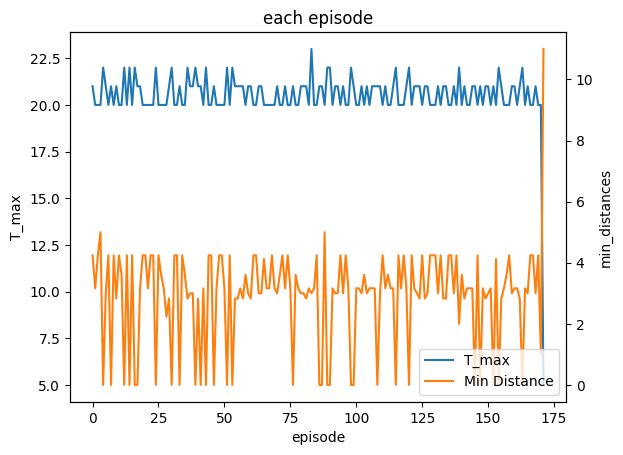

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()

# row[2] == -1 はエピソード終了時の集計行
T_max = [row[2] for row in Reached_Analysis[1:] if row[3] == -1]  # row[2]がTで、row[3]がAgentID=-1
min_distances = [row[6] for row in Reached_Analysis[1:] if row[3] == -1]  # row[6]がmin_distance

# エピソード数を確認
num_episodes = len(T_max)
print(f"Number of completed episodes: {num_episodes}")

if num_episodes > 0:
    # データがある場合のみプロット
    ax1.plot(range(num_episodes), T_max, 'C0', label = 'T_max')
    ax2.plot(range(num_episodes), min_distances, 'C1', label = 'Min Distance')
    ax1.set_ylabel('T_max')
    ax2.set_ylabel('min_distances')
    ax1.set_xlabel('episode')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.legend(h1+h2, l1+l2, loc='lower right')
    ax1.set_title(f'each episode')
else:
    print("No episodes completed yet. Run more episodes before plotting.")

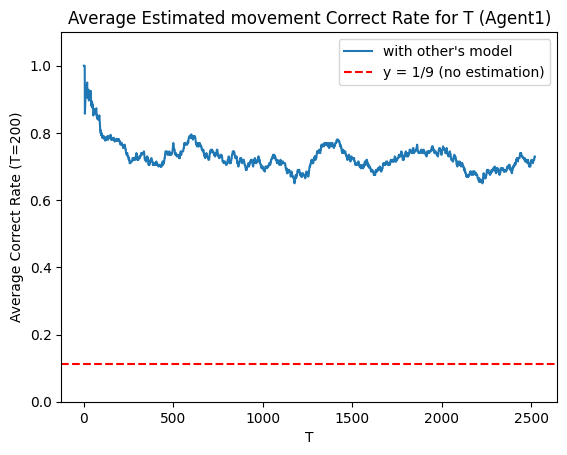

In [19]:
id = 1
correctRate = [row[7] for row in SaveData_Path[1:]][id::2] # [::2] means get Agent0's
SumWidth = 200
T_correctRate = [sum(correctRate[max(0,i-SumWidth+1):i+1])/min(SumWidth,i+1) for i in range(len(correctRate))] # 199=sum 200steps
plt.plot(range(1, len(T_correctRate[:2520]) +1), T_correctRate[:2520], label="with other's model")
plt.axhline(y=1/9., color='r', linestyle='--', label=f'y = 1/9 (no estimation)')
plt.ylabel(f'Average Correct Rate (T={SumWidth})')
plt.xlabel('T')
plt.ylim((0.,1.1))
plt.legend()
plt.title(f"Average Estimated movement Correct Rate for T (Agent{id})");

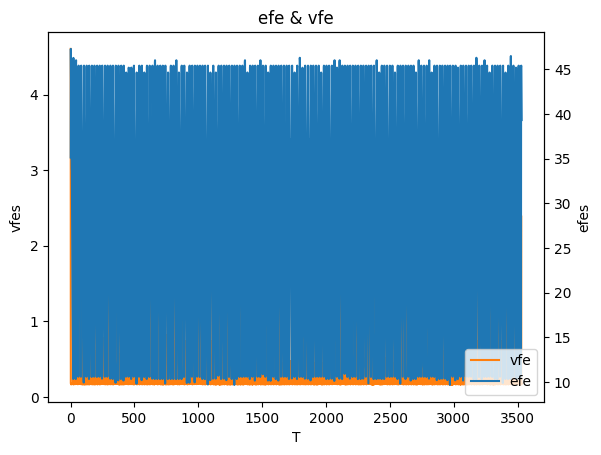

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()

efes = [row[5] for row in SaveData_Path[1:]][::2]
vfes = [row[6] for row in SaveData_Path[1:]][::2]
ax1.plot(range(1, len(vfes) +1), vfes, 'C1', label = 'vfe')
ax2.plot(range(1, len(efes) +1), efes, 'C0', label = 'efe')
ax1.set_ylabel('vfes')
ax2.set_ylabel('efes')
ax1.set_xlabel('T')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower right')
ax1.set_title(f'efe & vfe');

ValueError: x and y must have same first dimension, but have shapes (171,) and (0,)

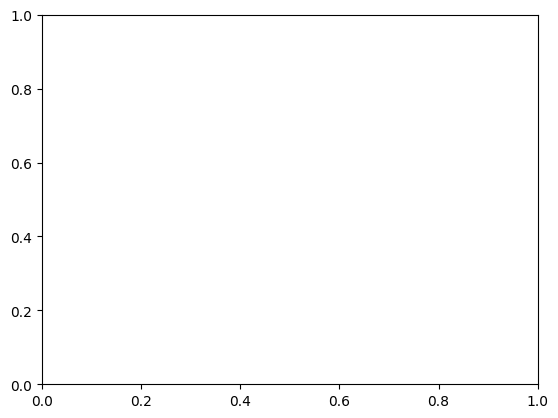

: 

In [ ]:
Agent0_path = [row[3] for row in Reached_Analysis[1:] if row[2] == 0]
Agent1_path = [row[3] for row in Reached_Analysis[1:] if row[2] == 1]
plt.plot(range(episode-1), Agent0_path[:-1], 'C0', label = 'Agent0')
plt.plot(range(episode-1), Agent1_path[:-1], 'C1', label = 'Agent1')
plt.ylabel(f'Length')
plt.xlabel('Episode')
plt.legend()
plt.title(f"Each Agent path length");

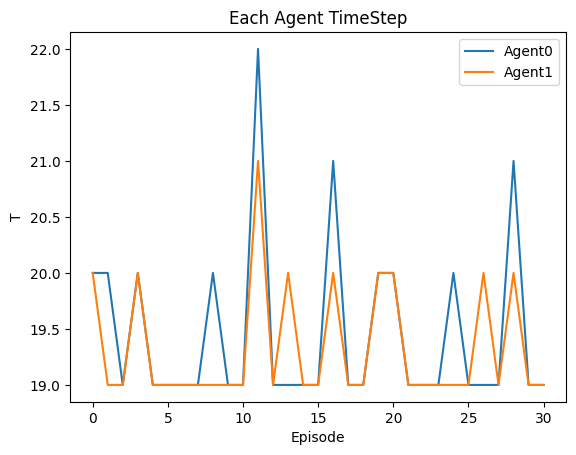

In [ ]:
Agent0_path = [row[1] for row in Reached_Analysis[1:] if row[2] == 0]
Agent1_path = [row[1] for row in Reached_Analysis[1:] if row[2] == 1]
plt.plot(range(episode-1), Agent0_path[:-1], 'C0', label = 'Agent0')
plt.plot(range(episode-1), Agent1_path[:-1], 'C1', label = 'Agent1')
plt.ylabel(f'T')
plt.xlabel('Episode')
plt.legend()
plt.title(f"Each Agent TimeStep");